## Demo: SPDE Mesh Generation

This notebook demonstrates mesh generation for SPDE approximations, building on the coordinate preprocessing demo.

#### Libraries

In [1]:
import os
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import geopandas as gpd
from plotnine import *

from geo_spde.coords import preprocess_coords
from geo_spde.mesh import SPDEMesh
from geo_spde.exceptions import CoordsError, MeshError

#### Load PM2.5 Data

Using the same North America PM2.5 ground monitor measurements

In [2]:
pm25 = pd.read_csv('north_america_pm25.csv')
print(f"Loaded {len(pm25)} PM2.5 observations")
pm25.head()

Loaded 1321 PM2.5 observations


,ISO3,Year,City,Longitude,Latitude,PM25,urban
0,1,2018,Whitehorse,-135.0588,60.71972,3.0,0
1,1,2019,Houston,-126.6468,54.39859,11.0,0
2,1,2019,Fort Mackay,-111.6424,57.14920,7.0,0
3,1,2019,Fort Mackay,-111.6405,57.18941,8.0,0
4,1,2019,Mallaig,-111.5026,54.21650,5.0,1


#### Step 1: Preprocess Coordinates

Using the enhanced preprocessing with duplicate detection

In [3]:
# Extract coordinates
pm25_coords = pm25[['Longitude','Latitude']].to_numpy()

# Preprocess with duplicate checking (not removing)
clean_coords, indices, proj_info = preprocess_coords(
    pm25_coords, 
    remove_duplicates=False  # Keep all points, just warn about close ones
)

Detected geographic coordinates (lon/lat)
Auto-detected scale: multi_region (diameter ≈ 10771.4 km)
Projected to: Albers Equal-Area Conic
Coordinate preprocessing complete: 1321 points retained
Projected extent: 9104307 × 6151368 meters


In [4]:
# Check if any close points were found
if 'close_points' in proj_info:
    print(f"\nFound {len(proj_info['close_points'])} pairs of close coordinates")
    for i, cp in enumerate(proj_info['close_points'][:5]):  # Show first 5
        print(f"  Points {cp['indices']}: {cp['distance']:.3f}m apart")
    if len(proj_info['close_points']) > 5:
        print(f"  ... and {len(proj_info['close_points'])-5} more")
else:
    print(f"no close points")

no close points


#### Step 2: Generate SPDE Mesh

Create triangular mesh with data-adaptive parameters

In [5]:
# Create mesh generator
mesh = SPDEMesh(clean_coords, proj_info)

# Generate mesh with default parameters
vertices, triangles = mesh.create_mesh(
    extension_factor=0.2,     # 20% boundary extension
    target_edge_factor=0.5,   # Edge length = 50% of median observation distance
    min_angle=20.0,          # Minimum triangle angle
    verbose=True
)

Creating mesh for 1321 observation points...
  Target edge length: 975085.6 units
  Cutoff distance: 10.974 units
  Created extended boundary (20% buffer)

Mesh Generation Complete:
  3,443 mesh vertices
  6,834 triangles
  Mesh/observation ratio: 2.6
  Total area: 48216820145517.8 units^2
  Estimated memory for Stan: 0.4 MB


In [6]:
# Get detailed mesh information
mesh_info = mesh.get_mesh_info()
print(f"\nMesh parameters:")
for key, value in mesh_info['mesh_params'].items():
    if isinstance(value, float):
        print(f"  {key}: {value:.3f}")
    else:
        print(f"  {key}: {value}")


Mesh parameters:
  max_edge: 975085.553
  max_area: 475395918251.988
  cutoff: 10.974
  min_distance: 109.741
  median_distance: 1950171.107


#### Visualize Mesh Structure

Create DataFrame for plotting mesh triangles

In [7]:
# Create edge list from triangles for plotting
edges = []
for tri in triangles:
    # Each triangle has 3 edges
    edges.append([tri[0], tri[1]])
    edges.append([tri[1], tri[2]])
    edges.append([tri[2], tri[0]])

# Remove duplicate edges
edges = np.array(edges)
edges = np.unique(np.sort(edges, axis=1), axis=0)

print(f"Mesh has {len(edges)} unique edges")

Mesh has 10276 unique edges


In [8]:
# Create DataFrame for edges
edge_df = []
for edge in edges:
    v1, v2 = edge
    edge_df.append({
        'x': vertices[v1, 0],
        'y': vertices[v1, 1],
        'xend': vertices[v2, 0],
        'yend': vertices[v2, 1]
    })
edge_df = pd.DataFrame(edge_df)

# Create DataFrame for vertices
vertex_df = pd.DataFrame({
    'x': vertices[:, 0],
    'y': vertices[:, 1],
    'type': ['observation' if i < len(clean_coords) else 'mesh' 
             for i in range(len(vertices))]
})

# Create DataFrame for observations
obs_df = pd.DataFrame({
    'x': clean_coords[:, 0],
    'y': clean_coords[:, 1],
    'PM25': pm25['PM25'].iloc[indices].values
})

#### Plot 1: Full Mesh Structure

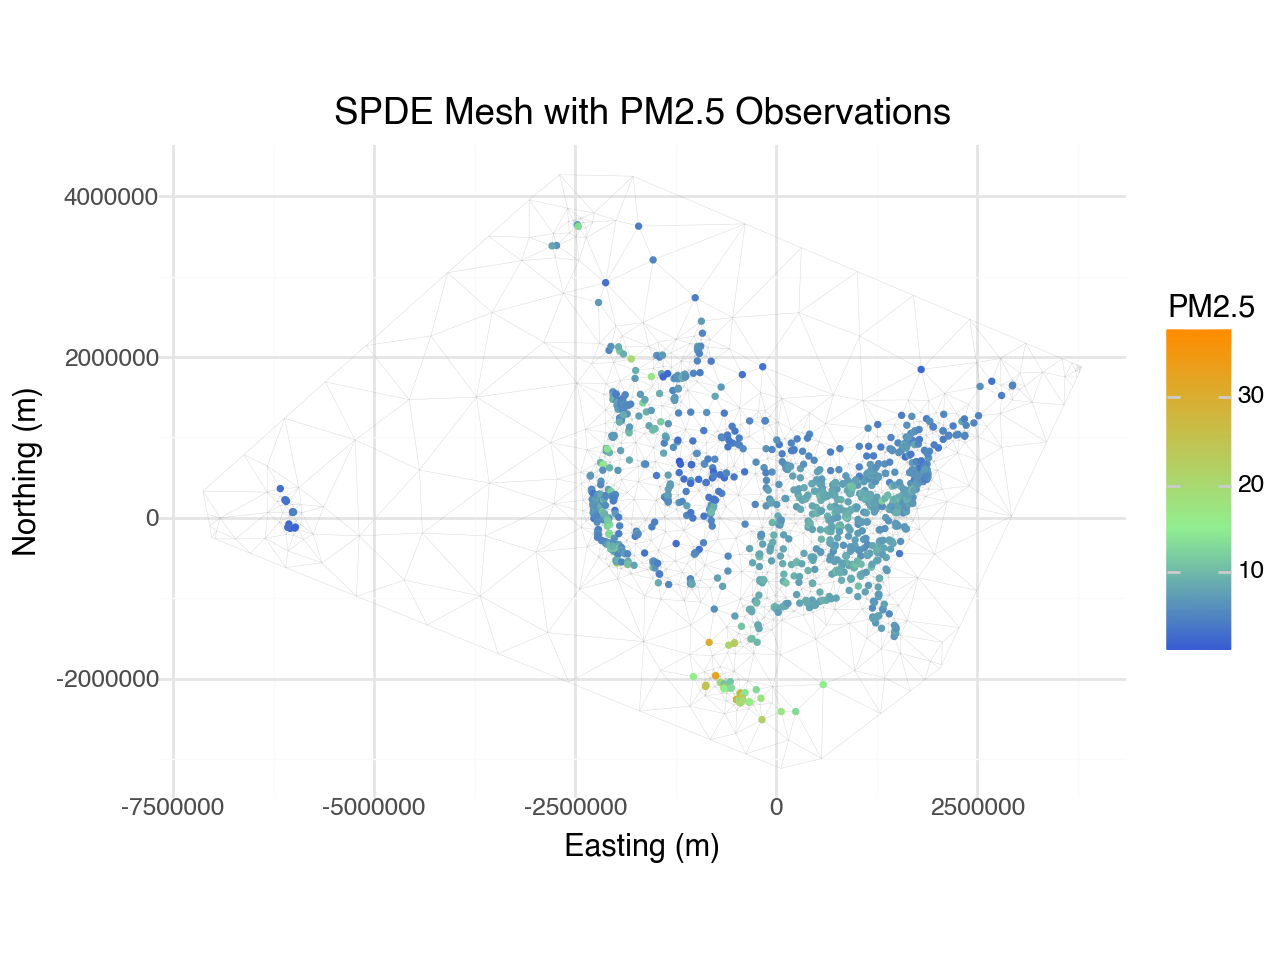

In [9]:
# Plot full mesh
p_mesh = (ggplot() +
    # Mesh edges
    geom_segment(data=edge_df,
                 mapping=aes(x='x', y='y', xend='xend', yend='yend'),
                 color='gray', alpha=0.3, size=0.1) +
    # Observation points
    geom_point(data=obs_df,
               mapping=aes(x='x', y='y', color='PM25'),
               size=0.5) +
    scale_color_gradient2(low='blue', mid='lightgreen', high='darkorange',
                         midpoint=15, name='PM2.5') +
    theme_minimal() +
    labs(title="SPDE Mesh with PM2.5 Observations",
         x="Easting (m)", y="Northing (m)") +
    coord_fixed())

p_mesh

#### Plot 2: Zoomed View of Mesh Detail

Let's zoom in on a smaller region to see mesh structure better

In [10]:
# Find a region with good observation density
x_center = np.median(clean_coords[:, 0])
y_center = np.median(clean_coords[:, 1])
zoom_range = 5e5  # 500 km

# Filter data for zoomed region
zoom_mask_edges = (
    (edge_df['x'] >= x_center - zoom_range) & 
    (edge_df['x'] <= x_center + zoom_range) &
    (edge_df['y'] >= y_center - zoom_range) & 
    (edge_df['y'] <= y_center + zoom_range) &
    (edge_df['xend'] >= x_center - zoom_range) & 
    (edge_df['xend'] <= x_center + zoom_range) &
    (edge_df['yend'] >= y_center - zoom_range) & 
    (edge_df['yend'] <= y_center + zoom_range)
)

zoom_mask_obs = (
    (obs_df['x'] >= x_center - zoom_range) & 
    (obs_df['x'] <= x_center + zoom_range) &
    (obs_df['y'] >= y_center - zoom_range) & 
    (obs_df['y'] <= y_center + zoom_range)
)

zoom_mask_vertices = (
    (vertex_df['x'] >= x_center - zoom_range) & 
    (vertex_df['x'] <= x_center + zoom_range) &
    (vertex_df['y'] >= y_center - zoom_range) & 
    (vertex_df['y'] <= y_center + zoom_range)
)

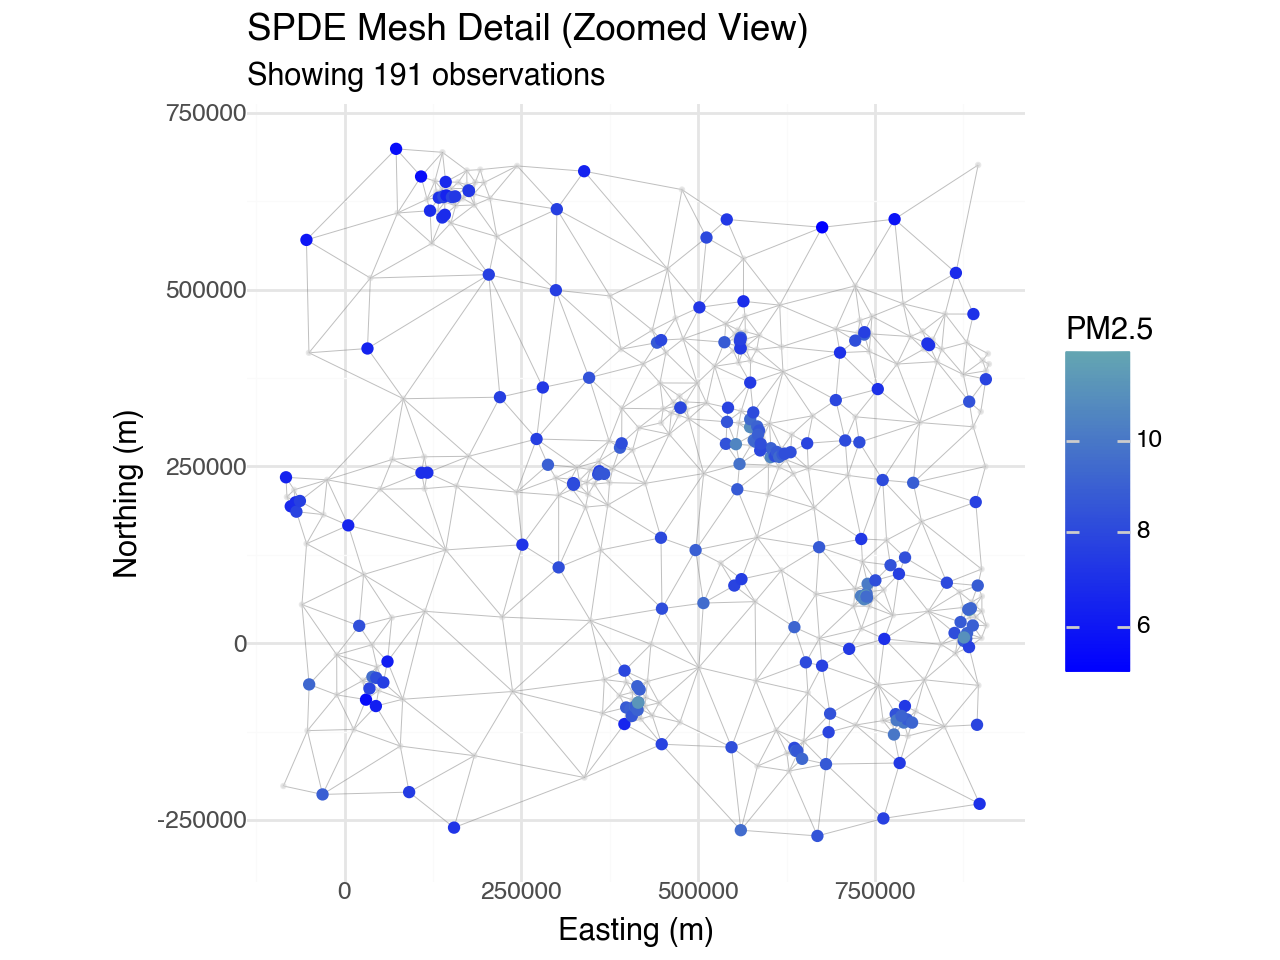

In [11]:
# Plot zoomed mesh
p_zoom = (ggplot() +
    # Mesh edges
    geom_segment(data=edge_df[zoom_mask_edges],
                 mapping=aes(x='x', y='y', xend='xend', yend='yend'),
                 color='gray', alpha=0.5, size=0.2) +
    # Mesh vertices (not observations)
    geom_point(data=vertex_df[zoom_mask_vertices & (vertex_df['type'] == 'mesh')],
               mapping=aes(x='x', y='y'),
               color='lightgray', size=0.3, alpha=0.5) +
    # Observation points
    geom_point(data=obs_df[zoom_mask_obs],
               mapping=aes(x='x', y='y', color='PM25'),
               size=1.5) +
    scale_color_gradient2(low='blue', mid='lightgreen', high='darkorange',
                         midpoint=15, name='PM2.5') +
    theme_minimal() +
    labs(title="SPDE Mesh Detail (Zoomed View)",
         subtitle=f"Showing {zoom_mask_obs.sum()} observations",
         x="Easting (m)", y="Northing (m)") +
    coord_fixed() +
    xlim(x_center - zoom_range, x_center + zoom_range) +
    ylim(y_center - zoom_range, y_center + zoom_range))

p_zoom

#### Mesh Quality Analysis

In [12]:
# Compute triangle quality metrics
triangle_areas = []
triangle_angles = []

for tri in triangles:
    v0, v1, v2 = vertices[tri]
    
    # Compute area
    area = 0.5 * abs((v1[0] - v0[0]) * (v2[1] - v0[1]) - 
                     (v2[0] - v0[0]) * (v1[1] - v0[1]))
    triangle_areas.append(area)
    
    # Compute angles
    edges = np.array([
        v1 - v0,
        v2 - v1,
        v0 - v2
    ])
    
    for i in range(3):
        e1 = edges[i]
        e2 = -edges[(i+1) % 3]
        cos_angle = np.dot(e1, e2) / (np.linalg.norm(e1) * np.linalg.norm(e2))
        cos_angle = np.clip(cos_angle, -1, 1)  # Handle numerical errors
        angle = np.degrees(np.arccos(cos_angle))
        triangle_angles.append(angle)

triangle_areas = np.array(triangle_areas)
triangle_angles = np.array(triangle_angles)

In [13]:
# Create quality summary
print("Triangle Quality Metrics:")
print(f"  Minimum angle: {triangle_angles.min():.1f} degrees")
print(f"  Maximum angle: {triangle_angles.max():.1f} degrees")
print(f"  Mean angle: {triangle_angles.mean():.1f} degrees")
print(f"  Triangles with angle < 20 degrees: {(triangle_angles < 20).sum()}")
print()
print(f"Triangle Area Statistics:")
print(f"  Min area: {triangle_areas.min():.2e} units^2")
print(f"  Max area: {triangle_areas.max():.2e} units^2")
print(f"  Mean area: {triangle_areas.mean():.2e} units^2")
print(f"  Area ratio (max/min): {triangle_areas.max()/triangle_areas.min():.1f}")

Triangle Quality Metrics:
  Minimum angle: 20.0 degrees
  Maximum angle: 139.7 degrees
  Mean angle: 60.0 degrees
  Triangles with angle < 20 degrees: 0

Triangle Area Statistics:
  Min area: 1.62e+04 units^2
  Max area: 4.68e+11 units^2
  Mean area: 7.06e+09 units^2
  Area ratio (max/min): 28829116.6


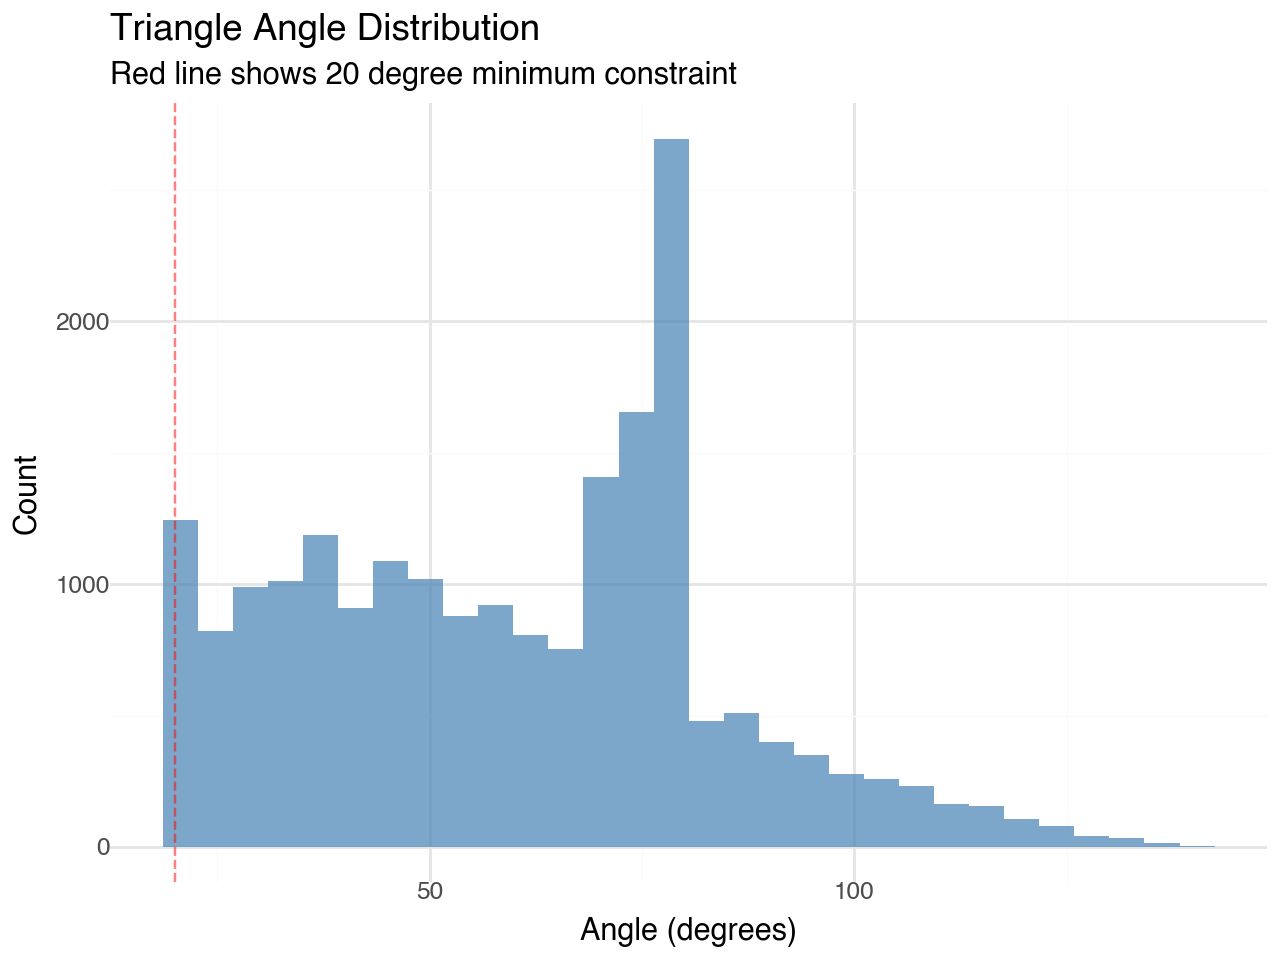

In [14]:
# Plot angle distribution
angle_df = pd.DataFrame({'angle': triangle_angles})

p_angles = (ggplot(angle_df, aes(x='angle')) +
    geom_histogram(bins=30, fill='steelblue', alpha=0.7) +
    geom_vline(xintercept=20, color='red', linetype='dashed', alpha=0.5) +
    theme_minimal() +
    labs(title="Triangle Angle Distribution",
         subtitle="Red line shows 20 degree minimum constraint",
         x="Angle (degrees)",
         y="Count"))

p_angles

#### Test Different Mesh Resolutions

In [15]:
# Compare different mesh resolutions
resolutions = [0.3, 0.5, 0.7]  # Different target_edge_factors
mesh_comparison = []

for factor in resolutions:
    mesh_test = SPDEMesh(clean_coords, proj_info)
    vertices_test, triangles_test = mesh_test.create_mesh(
        target_edge_factor=factor,
        verbose=False
    )
    
    mesh_comparison.append({
        'edge_factor': factor,
        'n_vertices': len(vertices_test),
        'n_triangles': len(triangles_test),
        'ratio': len(vertices_test) / len(clean_coords),
        'memory_mb': mesh_test.diagnostics['memory_estimate_mb']
    })

comparison_df = pd.DataFrame(mesh_comparison)
print("Mesh Resolution Comparison:")
print(comparison_df.to_string(index=False))

Mesh Resolution Comparison:
 edge_factor  n_vertices  n_triangles    ratio  memory_mb
         0.3        3510         6960 2.657078   0.405144
         0.5        3443         6834 2.606359   0.397987
         0.7        3430         6813 2.596518   0.396599


#### Summary

The mesh generation successfully:
1. Created a quality triangular mesh from observation coordinates
2. Used data-adaptive parameters based on observation density
3. Extended the boundary to avoid edge effects
4. Maintained minimum angle constraints for numerical stability

This mesh is ready for computing the FEM matrices (A, C, G) needed for Stan SPDE models.